# Codebase for "A Dynamic Theory of Deterrence and Compliance"

Format: JupyterLab Notebook

Kernel: Python3

Code for all results and figures. 

*Note, to use this file user must first set the local path to store results of computation.*

In [2]:
""" 
    import libraries and set display options 
"""
import sys
import matplotlib.collections

import random as rn
import numpy as np
import math as math
import quantecon as qe
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from numba import jit


path_data = 
path_code = 
path_figs = 

In [3]:
""" 
    baseline model parameters for kernel
    
"""
# main parameters
agents = 100
Z = 1, 2

# distribution parameters
ḡ , σ = 0.6 , 0.2

# Bayesian priors
α, β = 1, 0.25

# costs
ρ, λ = 2 , 5

# domain of analysis for policy
F = 1
R_low, R_high = 0, agents+1

# benchmarking parameters
block = 50000
checks, C = 5, 0.01

In [15]:
""" 
    functions used by simulations 
"""

# apprehension function, min catch
@jit(nopython=True)
def Apprehend(v, R):
    γ = 0.80 
    if v == 0:
        prob_a = γ
    else:
        prob_a = γ*min(1, R/v)
    return prob_a

# create a distribution of 'criminal opportunities'
@jit(nopython=True)
def Criminal_opps(μ, σ, agents, T):
    g = np.zeros((T,agents))
    for i in range(T):
        g[i] = [max(0, np.random.normal(ḡ, σ)) for agent in range(agents)]
    return g

def Simulation(criminal_opps, R, F, Z):
# agent priors
    α,β = 1, 0.25
    init_period = 100
# tracking arrays for endogenous variables of interest
    a_t,v_t, g_t, q_t = [], [], [], []
# seed for priors
    append_v = v_t.append
    append_a = a_t.append
    append_g = g_t.append
    append_q = q_t.append
    for t in range(Z):
        v = np.random.randint(1,agents)
        a = np.random.randint(0,v)
        append_v(v)
        append_a(a)
# main sim loop, starts at T = 500   
    for t in range(len(criminal_opps)):
        a, v, g, q = 0, 0, 0, 0
        q = (α + np.sum(a_t[-Z:]))/(α + β + np.sum(v_t[-Z:]))
        for g_i in criminal_opps[t]:
            if  q <= g_i/F:
                v = v + 1
                g = g + g_i
        a = stats.binom.rvs(v, Apprehend(v, R))
        append_v(v)
        append_a(a)
        append_g(g)
        append_q(q)
    
    return np.array(v_t[init_period+Z:]), np.array(a_t[init_period+Z:]), np.array(g_t[init_period+Z:]), np.array(q_t[init_period+Z:])

def equilibrium_sim_pareto(ḡ, σ, R, agents, runs):
    pareto_equilibria = np.zeros(runs)
    for run in range(0,runs):
        equilibria = []
        G = -np.sort(-Criminal_opps(ḡ,σ,agents,1))
        for v in range(agents+1):
            if len([i for i in G[0] if i >= Apprehend(v,R)]) == v:
                if len([i for i in G[0] if i >= Apprehend(v+1,R)]) == v:
                    equilibria.append(v)
        pareto_equilibria[run] = min(equilibria)

    return pareto_equilibria

def equilibrium_sim_random(ḡ, σ, R, agents, runs):
    random_equilibria = np.zeros(runs)
    for run in range(0,runs):
        equilibria = []
        G = -np.sort(-Criminal_opps(ḡ,σ,agents,1))
        for v in range(agents+1):
            if len([i for i in G[0] if i >= Apprehend(v,R)]) == v:
                if len([i for i in G[0] if i >= Apprehend(v+1,R)]) == v:
                    equilibria.append(v)
        random_equilibria[run] = rn.choice(equilibria)

    return random_equilibria  

In [21]:
run_dyn = 100000
run_eqm = 100000
reserve_capacity = np.zeros((3,agents+1))
deficient_capacity = np.zeros((3,agents+1))
compliance = np.zeros((3,agents+1))

for R in range(0,agents+1):
    criminal_opps = Criminal_opps(ḡ,σ,agents,run_dyn)
    v, a, g, q = Simulation(criminal_opps,R,F,Z)
    compliance[0][R] = agents - np.mean(v)
    for v_t in v:
        reserve_capacity[0][R] = reserve_capacity[0][R] + max(0,R-v_t)
        deficient_capacity[0][R] = deficient_capacity[0][R] + min(0,R-v_t)
    v = equilibrium_sim_random(ḡ, σ, R, agents, run_eqm)
    compliance[1][R] = agents - np.mean(v)
    for v_t in v:
        reserve_capacity[1][R] = reserve_capacity[1][R] + max(0,R-v_t)
        deficient_capacity[1][R] = deficient_capacity[1][R] + min(0,R-v_t)
    v = equilibrium_sim_pareto(ḡ, σ, R, agents, run_eqm)
    compliance[2][R] = agents - np.mean(v)
    for v_t in v:
        reserve_capacity[2][R] = reserve_capacity[2][R] + max(0,R-v_t)
        deficient_capacity[2][R] = deficient_capacity[2][R] + min(0,R-v_t)
     

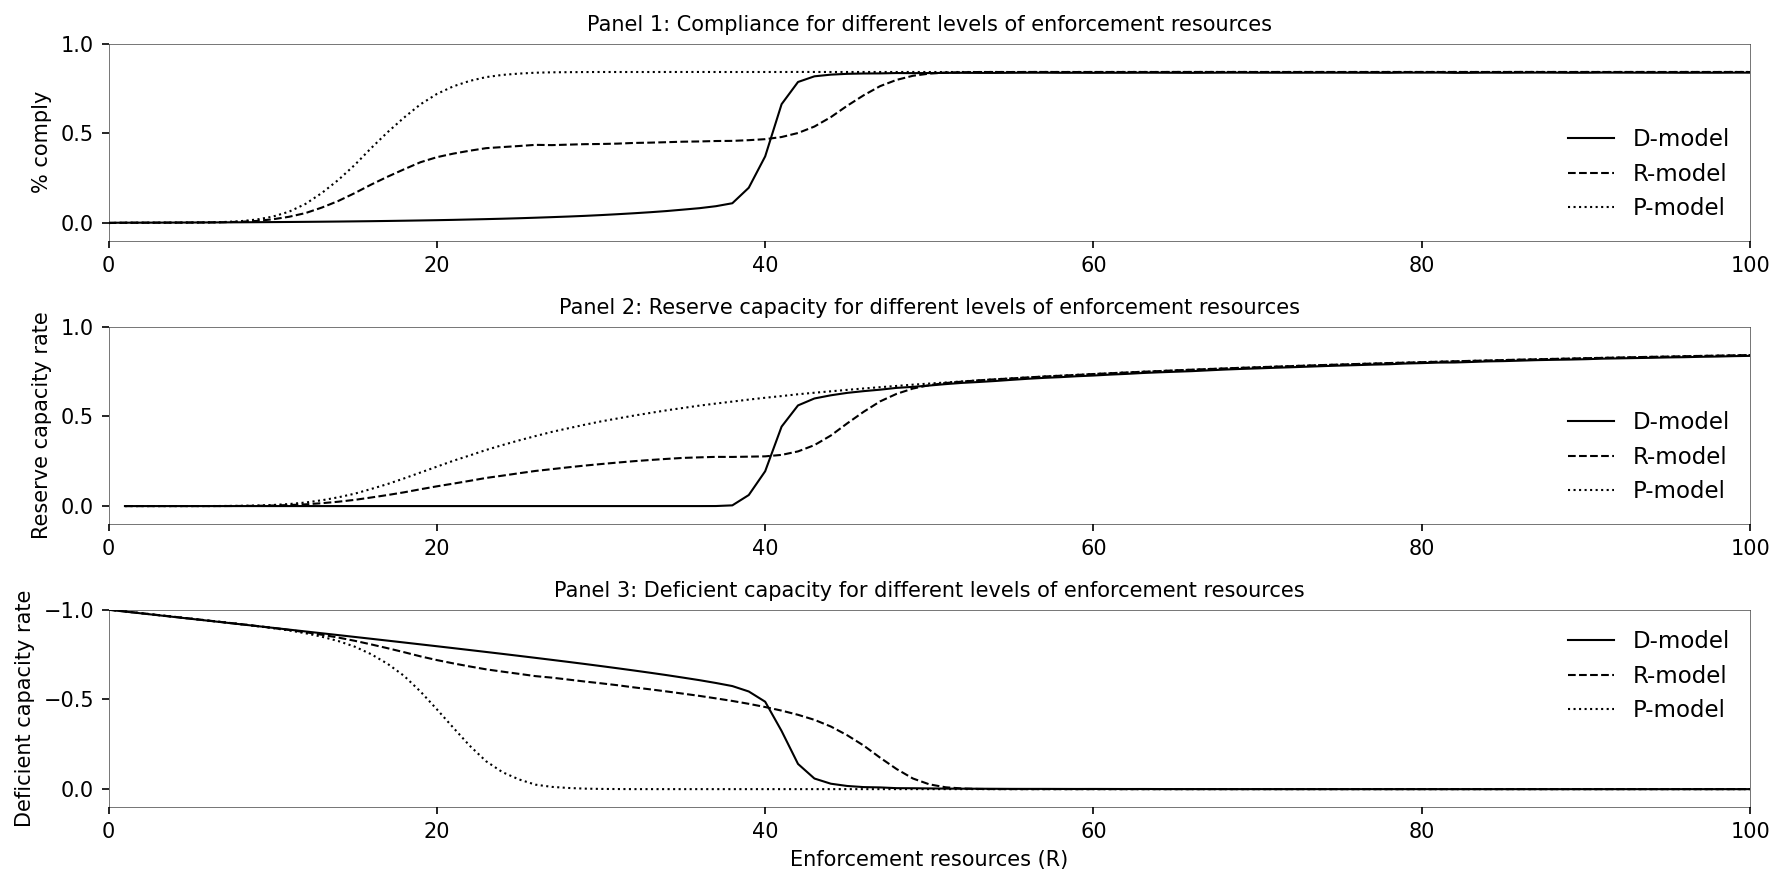

In [39]:
R_range = np.arange(0,agents+1)

fig = plt.figure(figsize=(12,6),tight_layout=True,dpi=150)
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.25)
    ax2.spines[axis].set_linewidth(0.25)
    ax3.spines[axis].set_linewidth(0.25)

ax1.set_title('Panel 1: Compliance for different levels of enforcement resources', fontsize= 'medium')
ax1.set_ylabel('% comply', fontsize= 10)
ax1.set_xlim([0,100])
ax1.set_ylim([-0.1,1])
ax1.plot(compliance[0]/agents, color='k', linestyle='solid', linewidth=1, label='D-model')
ax1.plot(compliance[1]/agents, color='k', linestyle='dashed', linewidth=1, label='R-model')
ax1.plot(compliance[2]/agents, color='k', linestyle='dotted', linewidth=1, label='P-model')
ax1.legend(loc='lower right', frameon=False, fontsize=11)

ax2.set_title('Panel 2: Reserve capacity for different levels of enforcement resources', fontsize= 'medium')
ax2.set_ylabel('Reserve capacity rate', fontsize= 10)
ax2.set_xlim([0,100])
ax2.set_ylim([-0.1,1])
ax2.plot((reserve_capacity[0]/run_dyn)/R_range, color='k', linestyle='solid', linewidth=1, label='D-model')
ax2.plot((reserve_capacity[1]/run_eqm)/R_range, color='k', linestyle='dashed', linewidth=1, label='R-model')
ax2.plot((reserve_capacity[2]/run_eqm)/R_range, color='k', linestyle='dotted', linewidth=1, label='P-model')
ax2.legend(loc='lower right', frameon=False, fontsize=11)

ax3.set_title('Panel 3: Deficient capacity for different levels of enforcement resources', fontsize= 'medium')
ax3.set_xlabel('Enforcement resources (R)', fontsize= 'medium')
ax3.set_ylabel('Deficient capacity rate', fontsize= 10)
ax3.set_xlim([0,100])
ax3.set_ylim([0.1,-1])
ax3.plot((deficient_capacity[0]/run_dyn)/(agents-compliance[0]), color='k', linestyle='solid', linewidth=1, label='D-model')
ax3.plot((deficient_capacity[1]/run_eqm)/(agents-compliance[1]), color='k', linestyle='dashed', linewidth=1, label='R-model')
ax3.plot((deficient_capacity[2]/run_eqm)/(agents-compliance[2]), color='k', linestyle='dotted', linewidth=1, label='P-model')
ax3.legend(loc='upper right', frameon=False, fontsize=11)

#plt.savefig();